In [1]:
import os
import sys

In [8]:
os.getcwd()
sys.path.append("../rfgi")

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from mpl_toolkits.mplot3d import Axes3D

# from CARTGV import CARTGVTree, CARTGVTreeBuilder
# from CARTGV import CARTGVSplitter, BaseDenseCARTGVSplitter, BestCARTGVSplitter
# from CARTGV import CARTGVCriterion, CARTGVClassificationCriterion, CARTGVGini

from CARTGV_trees import DecisionCARTGVTreeClassifier, DecisionCARTGVTreeRegressor
from RFGV import RFGVClassifier, RFGVRegressor

from sklearn.utils.validation import check_random_state
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.datasets import load_iris, load_diabetes
from sklearn.model_selection import train_test_split

# Data

In [82]:
#Loading of the data
data = load_iris()

X = data.data
y= data.target

#Split the data into train and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Represent the groups as an array containing the indexes of the group column/variable inside the data
# Here on the iris dataset we chose to regroup :
# Sepal Length and Sepal Width : Group 0
# Petal Length and Petal Width : Group 1
# Sepal Length and Petal Length : Group 2
# Sepal Width and Petal Width : Group 3
groups = np.array([[0,1],[2,3],[0,2],[1,3]])


# A supprimer

# #Import of the data
# df = pd.read_csv('CARTGV/data_Mael.csv', sep=";", index_col=0)

# # Select only the train samples
# train = df.loc[df['Type'] == 'train']

# # Remove the first two columns of the dataframe
# X = train.iloc[:, 2:]

# # Select the responses for the train samples
# y = train['Y']

# # Select the index of each column for each group
# g1_idx = [col for col in range(len(X.columns)) if '_G1' in X.columns[col]]
# g2_idx = [col for col in range(len(X.columns)) if '_G2' in X.columns[col]]
# g3_idx = [col for col in range(len(X.columns)) if '_G3' in X.columns[col]]
# g4_idx = [col for col in range(len(X.columns)) if '_G4' in X.columns[col]]
# g5_idx = [col for col in range(len(X.columns)) if '_G5' in X.columns[col]]

# # Represent the groups as an array containing the index of the group column/variable inside the dataframe
# groups = np.array([g1_idx, g2_idx, g3_idx, g4_idx, g5_idx])

# Data representation

In [84]:
print(data.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

<ipython-input-52-432b36512c3e>:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


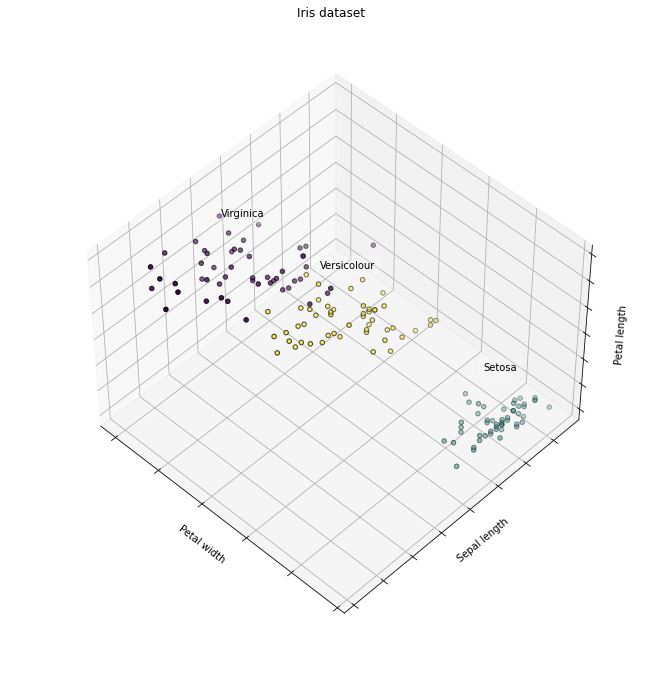

In [52]:
# Plot the data
fig = plt.figure(0, figsize=(16, 9))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

for name, label in [('Setosa', 0),
                    ('Versicolour', 1),
                    ('Virginica', 2)]:
    ax.text3D(X[y == label, 3].mean(),
              X[y == label, 0].mean(),
              X[y == label, 2].mean() + 2, name,
              horizontalalignment='center',
              bbox=dict(alpha=.2, edgecolor='w', facecolor='w'))
# Reorder the labels to have colors matching the cluster results
y_reordered = np.choose(y, [1, 2, 0]).astype(float)
ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=y_reordered, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Petal width')
ax.set_ylabel('Sepal length')
ax.set_zlabel('Petal length')
ax.set_title('Iris dataset')
ax.dist = 12

fig.show()

On the figure above we can see the Iris dataset and it's representation.

We can see 3 of the 4 variables which are Petal Length, Sepal length, Petal Width and Sepal Width.

We can also see that the dataset is composed of 3 classes, Virginica, Versicolour and Setosa.

Moreover, in this representation, we cna see an important variable, Petal Width, that will split the dataset in the correct classes. We will later compare it to our result.

# Parameters

We will now define our parameter for our tree construction.

In [20]:
sample_size = X_train.shape[0]
# Xs = X_train.head(sample_size).to_numpy(dtype=np.float32)
# ys = y_train.head(sample_size).to_numpy(dtype=np.intp)

len_groups = np.array([len(group) for group in groups])

# ys = np.atleast_1d(y_train)
min_samples_leaf = 1 # The minimum number of samples in a leaf
min_samples_split = 2 # The minimum number of samples needed to split the node
min_weight_leaf = 0 # The minimum weight in a leaf
random_state = 2547 # The seed
max_depth = 10 # The maximal depth for the splitting_tree
max_depth_splitting_tree = 2
mgroup = len(groups) # The number of group to visit
mvar = len_groups # The number of variable to visit
min_impurity_decrease = 0.0 # The minimum decrease in impurity that we want to achieve after a split
min_impurity_split = 0.0 # The minimum impurity under which the node is considered a leaf
min_impurity_decrease_splitting_tree = 0.0
min_impurity_split_splitting_tree = 0.0


# A supprimer

# if ys.ndim == 1:
#     ys = np.reshape(ys, (-1, 1))

# n_outputs = ys.shape[1] # The number of outputs

# ys = np.copy(ys)

# classes = [] # The different classes
# n_classes = [] # The number of classes

# ys_encoded = np.zeros(ys.shape, dtype=int)
# for k in range(n_outputs):
#     classes_k, ys_encoded[:, k] = np.unique(ys[:, k], return_inverse=True)
#     classes.append(classes_k)
#     n_classes.append(classes_k.shape[0])

# ys = ys_encoded

# n_classes = np.array(n_classes, dtype=np.intp)

# Example 1 : Iris dataset and multi-classes classification

## Objects construction

In [55]:
cartgvtreeclassifier = DecisionCARTGVTreeClassifier(mvar=mvar, 
                            mgroup=mgroup,
                            random_state=random_state, 
                            max_depth_splitting_tree=max_depth_splitting_tree)

## Tree construction

In [56]:
cartgvtreeclassifier.fit(X_train, y_train, groups) #.to_numpy(dtype=np.float32)
# The pen parameter can take the value : "root", "size", "log", None, 
# or a lambda function with only one argument for the group size
#If the data doesn't come from a pandas Dataframe remove the to_numpy

DecisionCARTGVTreeClassifier(mgroup=4, mvar=array([2, 2, 2, 2]),
                             random_state=2547)

## Classification score

In [57]:
cartgvtreeclassifier.score(X_test, y_test)

0.96

In [54]:
# A supprimer

# # The criterion that will compute the impurities
# criterion = CARTGVGini(n_outputs, n_classes) 

# # The splitter that will split each node
# splitter = BestCARTGVSplitter(criterion, len(groups),
#                           min_samples_leaf, min_weight_leaf,
#                           random_state, max_depth_splitting_tree, 
#                           min_impurity_decrease_splitting_tree,
#                           min_impurity_split_splitting_tree,
#                           mvar,
#                           mgroup
#                         )

# # The tree that will be completed by the end of the algorithm 
# tree = CARTGVTree(len(groups), len_groups, n_classes, n_outputs)

# # The Builder that will fill the tree during the process
# builder = CARTGVTreeBuilder(splitter, min_samples_split,
#                             min_samples_leaf, min_weight_leaf,
#                             max_depth, min_impurity_decrease, min_impurity_split)

# Results and visualisation

## Parents
Each number represent the parent of the node with the id the index of the array.
The parent -2 represent the root

In [58]:
print(cartgvtreeclassifier.tree_.nodes_parent)

[-2.  0.  1.  1.  1.  0.  5.  5.  7.  7.  5. 10. 10. 10.  0.]


## Impurities
Each value is the value of the node with the id the index of the array

In [59]:
print(cartgvtreeclassifier.tree_.nodes_impurities)

[0.6658     0.06243496 0.         0.         0.         0.18836565
 0.         0.5        0.         0.         0.05709343 0.
 0.         0.         0.        ]


## Number of samples in each node

In [60]:
print(cartgvtreeclassifier.tree_.nodes_n_node_samples)
print('\n')
print(cartgvtreeclassifier.tree_.nodes_weighted_n_node_samples)

[100.  31.  28.   2.   1.  38.   2.   2.   1.   1.  34.  31.   1.   2.
  31.]


[100.  31.  28.   2.   1.  38.   2.   2.   1.   1.  34.  31.   1.   2.
  31.]


## Groups
Represent the group that splited the node.
A value of -1 means the node is a leaf and wasn't splitted.

In [61]:
print(cartgvtreeclassifier.tree_.nodes_group)

[ 1.  2. -2. -2. -2.  1. -2.  1. -2. -2.  3. -2. -2. -2. -2.]


## Number of childs

In [62]:
print(cartgvtreeclassifier.tree_.nodes_n_childs)

[3. 3. 0. 0. 0. 3. 0. 2. 0. 0. 3. 0. 0. 0. 0.]


## Number of nodes in the CARTGVTree

In [63]:
print(cartgvtreeclassifier.tree_.node_count)

15


## Splitting trees
In order of split

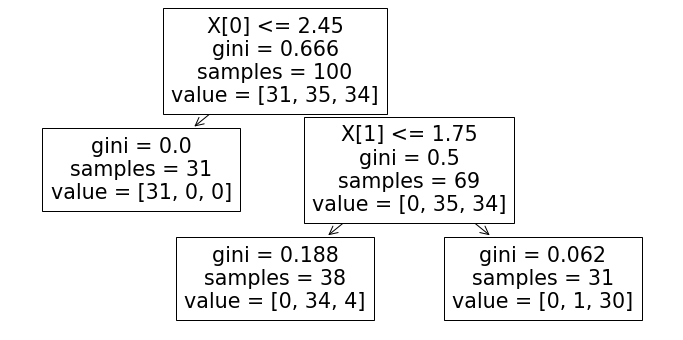

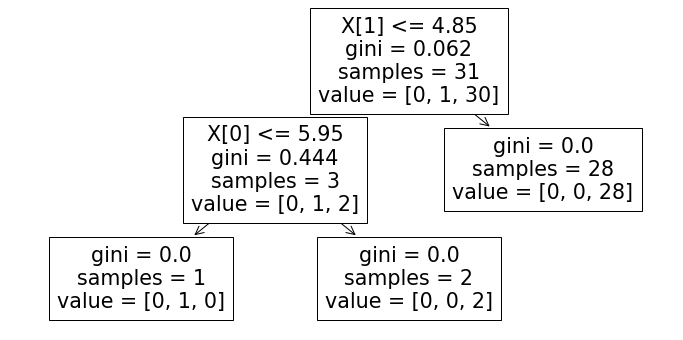

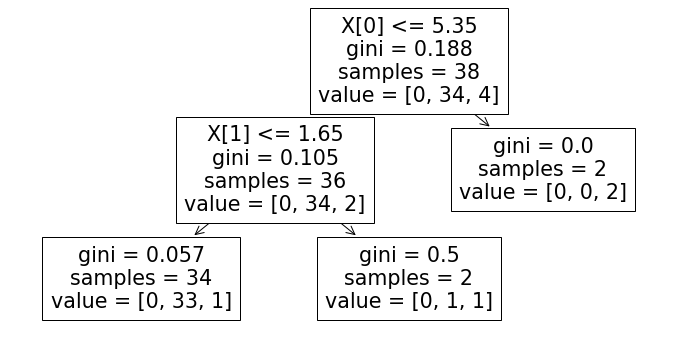

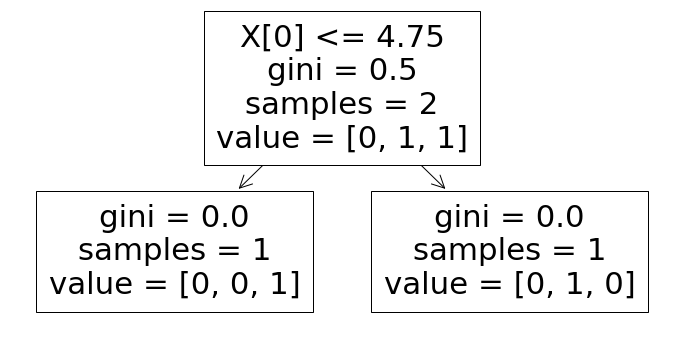

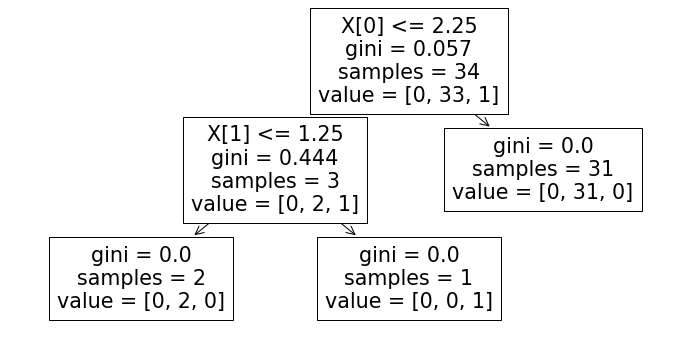

In [64]:
clf = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state, max_features=len(groups[0]),
                             max_leaf_nodes=X.shape[0])

for i in range(cartgvtreeclassifier.tree_.node_count):
    clf.tree_ = cartgvtreeclassifier.tree_.nodes_splitting_trees[i]
    if(cartgvtreeclassifier.tree_.nodes_splitting_trees[i] != None):
        fig, ax = plt.subplots(1, figsize=(12, 6))
        plot_tree(clf)
        plt.show()

# Example 2 : Diabetes dataset and regression

In [87]:
#Loading of the data
data = load_diabetes()
X = data.data
y = data.target

#Split the data into train and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Represent the groups as an array containing the indexes of the group column/variable inside the data
# Here on the iris dataset we chose to regroup :
# Sepal Length and Sepal Width : Group 0
# Petal Length and Petal Width : Group 1
# Sepal Length and Petal Length : Group 2
# Sepal Width and Petal Width : Group 3
groups = np.array([[0,1],[2,3],[0,2],[1,3]])

In [88]:
print(data.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, T-Cells (a type of white blood cells)
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, thyroid stimulating hormone
      - s5      ltg, lamotrigine
      - s6      glu, blood sugar level

Note: Each of these 10 feature va